# U10 - Abdullah Barhoum (5041774), Katharina Müller (5284090)


# Assignment 10 - UNet

In this assignement we are going to program our own UNet network (https://arxiv.org/pdf/1505.04597.pdf) which is a simple but powerful one. This network is made to produce a segmentation map. This segmentation map can be a little bit smaller than the true map but keep the same spatial structure. This map however is composed of several layers, one per class. The goal for the network is to activate pixel-wisely a layer if the pixel are representing the object of the layer.

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png", width=700)

The network look this way. The descending part is simply made out of convolution layer and pooling, easy peasy. This part of the network allow a move from the "Where?" information to the "What?" information. Then the informations are spatially dilated through a so called "transpose convolution" looking like a convoltuion mixed with an inverse pooling and then you convolute. as I sayed above, there is one layer of exit per class, don't trust the drawing, the initial version of this network was only design to say yes or not (That why there is two output layer)

In [2]:
Image(url= "https://miro.medium.com/max/3200/0*mk6U6zQDuoQLK7Ca", width=700)

After each big step of convolution, the informations are stacked to the last part of the network (grey arrow) reinjecting this way the "Where?" information.

# 8.1

Yo have to reproduce this network by yourself. The images takken for this work come from the PascalVOC database (http://host.robots.ox.ac.uk/pascal/VOC/). Here you inject RGB images into your network and out a "cube" of maps. The label of the data are on the shape of images with one channel, the background is represented by 0 and the differents class by a unique label (all the pixel filled out of ones are representing a plan typically.)

You have to use dtype=torch.float32 for the images and dtype=torch.long for the mask and every thing should run perfectly. Use also the criterion to use should be criterion = nn.CrossEntropyLoss() because he can understand the type of label injected (https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss). 

Try to work on this early, the training can be slow (like 1h for 50 epoch ; batch : 100)

In [3]:
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
from torch.autograd import Function
from torch.utils.data import DataLoader, random_split
from matplotlib import pyplot as plt
from PIL import Image
import random

In [4]:
class_names = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 
          'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor' ]

In [5]:
class VOCSegLoader(torchvision.datasets.VOCSegmentation):
    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is the image segmentation.
        """
        img = Image.open(self.images[index]).convert('RGB')
        target = Image.open(self.masks[index])
        target = np.array(target)
        target[target == 255] = 0
        target = Image.fromarray(target)
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        target = torch.as_tensor(np.asarray(target, dtype=np.uint8), dtype=torch.long)
        return img, target

In [6]:
batch_size_train = 100
batch_size_val = 100
image_size = (64, 80)

class SeededTransform():
    def __init__(self, transform, seed=1):
        self.seed = seed
        self.transform = transform

    def __call__(self, *args):
        s = self.seed
        torch.manual_seed(s); torch.cuda.manual_seed(s); np.random.seed(s); random.seed(s);
        self.seed += 1
        return self.transform(*args)


class RandomRectangleCrop():
    def __call__(self, x):
        W, H = x.size
        diff = abs(H - W)
        r = random.randint(0, diff)
        if H > W:
            return x.crop((0, r, W, r + W))
        else:
            return x.crop((r, 0, r + H, H))


CROP_SIZE = (300, 300)
RANDOM_ROTATION_RANGE = 20
transform_data = T.Compose([
    SeededTransform(T.RandomRotation(RANDOM_ROTATION_RANGE)),
    SeededTransform(RandomRectangleCrop()),
    SeededTransform(T.RandomHorizontalFlip()),
    T.Resize(image_size),
    T.ToTensor()
])
transform_label = T.Compose([
    SeededTransform(T.RandomRotation(RANDOM_ROTATION_RANGE)),
    SeededTransform(RandomRectangleCrop()),
    SeededTransform(T.RandomHorizontalFlip()),
    T.Resize(image_size, interpolation=0)
])

train_dataset = VOCSegLoader('./data', '2012', 'train', False, transform_data,
                             transform_label)
val_dataset = VOCSegLoader('./data', '2012', 'val', False, transform_data,
                           transform_label)

train_loader = DataLoader(train_dataset, batch_size=batch_size_train)
val_loader = DataLoader(val_dataset, batch_size=batch_size_val)

<class 'torch.Tensor'> torch.Size([3, 64, 80])
<class 'torch.Tensor'> torch.Size([64, 80])


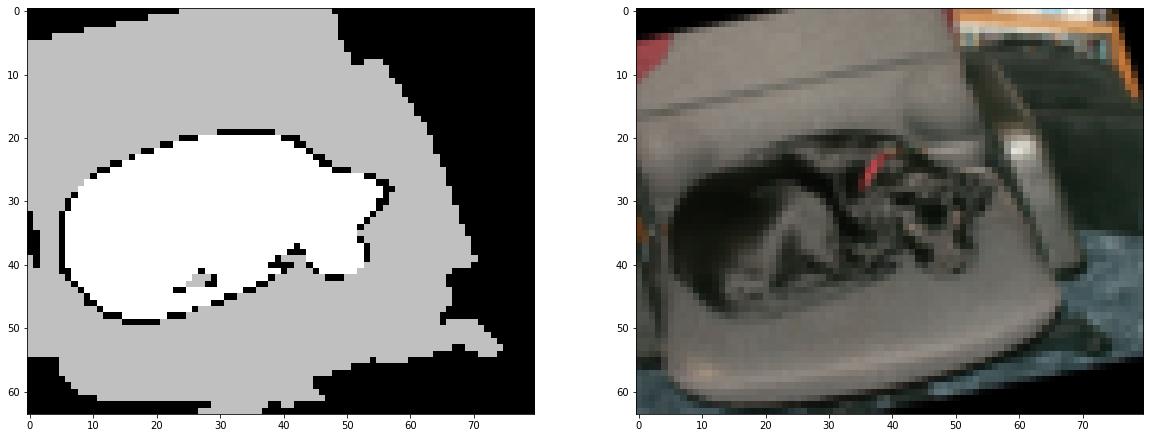

In [7]:
#
image, target = train_dataset[2]
print(type(image), image.size())
print(type(target), target.size())


def imshow(inp, cmap=None, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(20, 20))
    plt.axis('off')
    if title:
        plt.title(title)
    plt.imshow(inp, cmap=cmap)

def show_databatch(inputs):
    out = torchvision.utils.make_grid(inputs)
    imshow(out)
    
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].imshow(target.numpy(), cmap='gray')
ax[1].imshow(image.numpy().transpose((1, 2, 0)))

In [8]:
def create_block(c1, c2, c3 = None, sigmoid=False):
    if c3 == None:
        c3 = c2
    return nn.Sequential(
        nn.Conv2d(c1, c2, 3, stride=1, padding=1),
        nn.BatchNorm2d(c2),
        nn.LeakyReLU(0.5),
        nn.Conv2d(c2, c3, 3, stride=1, padding=1),
        nn.BatchNorm2d(c3),
        nn.Sigmoid() if sigmoid else nn.LeakyReLU(0.5)
    )
    
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.conv1 = create_block(3, 21)
        self.conv2 = create_block(21, 42)
        self.conv3 = create_block(42, 84)
        self.conv4 = create_block(84, 168)
        
        self.conv5 = create_block(168, 336)
        
        self.tconv1 = nn.ConvTranspose2d(336, 168, 4, 2, 1)
        self.tblock1 = create_block(336, 168)
        
        self.tconv2 = nn.ConvTranspose2d(168, 84, 4, 2, 1)
        self.tblock2 = create_block(168, 84)
        
        self.tconv3 = nn.ConvTranspose2d(84, 42, 4, 2, 1)
        self.tblock3 = create_block(84, 42)
        
        self.tconv4 = nn.ConvTranspose2d(42, 21, 4, 2, 1)
        self.tblock4 = create_block(42, 21, sigmoid=False)

    def forward(self, img):
        x1 = self.conv1(img)
        x2 = self.conv2(F.max_pool2d(x1, 2))
        x3 = self.conv3(F.max_pool2d(x2, 2))
        x4 = self.conv4(F.max_pool2d(x3, 2))
        x5 = self.conv5(F.max_pool2d(x4, 2))
        
        x4_2 = self.tblock1(torch.cat((x4, self.tconv1(x5))  , dim=1))
        x3_2 = self.tblock2(torch.cat((x3, self.tconv2(x4_2)), dim=1))
        x2_2 = self.tblock3(torch.cat((x2, self.tconv3(x3_2)), dim=1))
        x1_2 = self.tblock4(torch.cat((x1, self.tconv4(x2_2)), dim=1))
        
        return x1_2

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model =  UNet().to(device)
optimizer = optim.Adam(model.parameters(), 1e-4)
ce = nn.CrossEntropyLoss()
losses = []

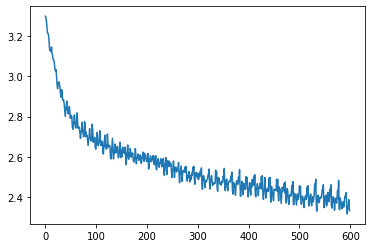

In [9]:
epoches= 40
for e in tqdm(range(epoches), leave=False):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(images)
        loss = ce(predictions, labels)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
    
plt.figure()
plt.plot(losses)
plt.show() 

In [13]:
with torch.no_grad():
    images, _ = next(iter(train_loader))
    predictions = model(images.to(device)).cpu()
    images = images.cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


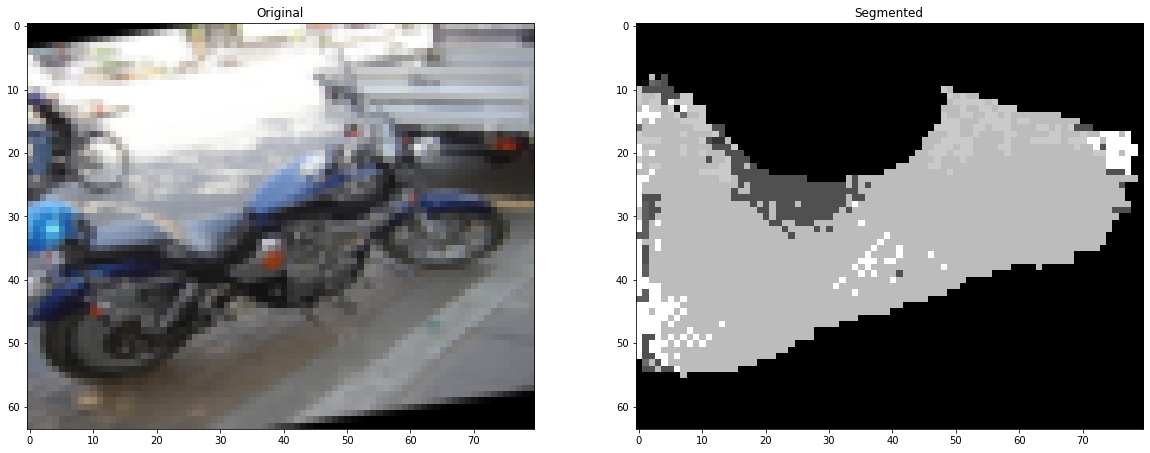

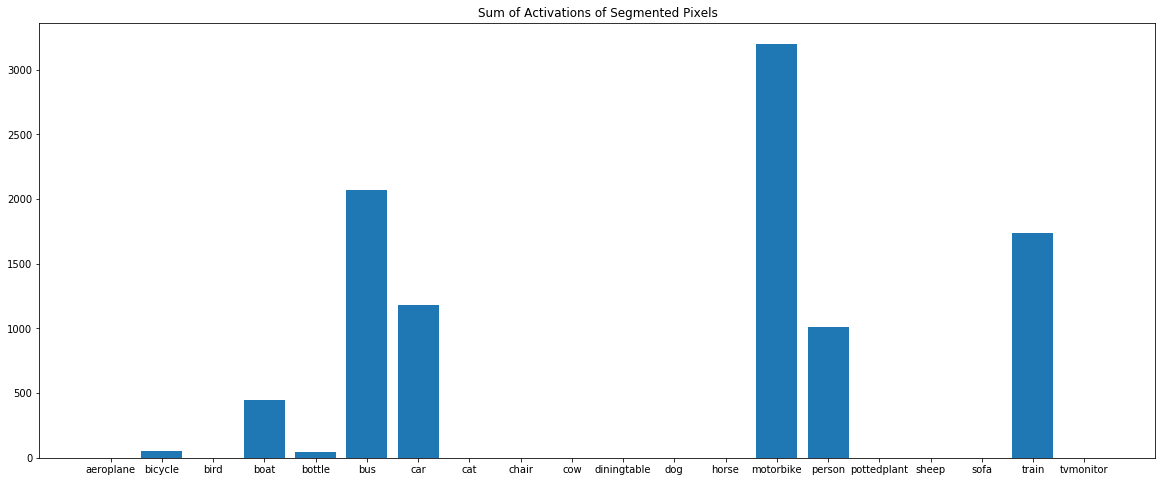

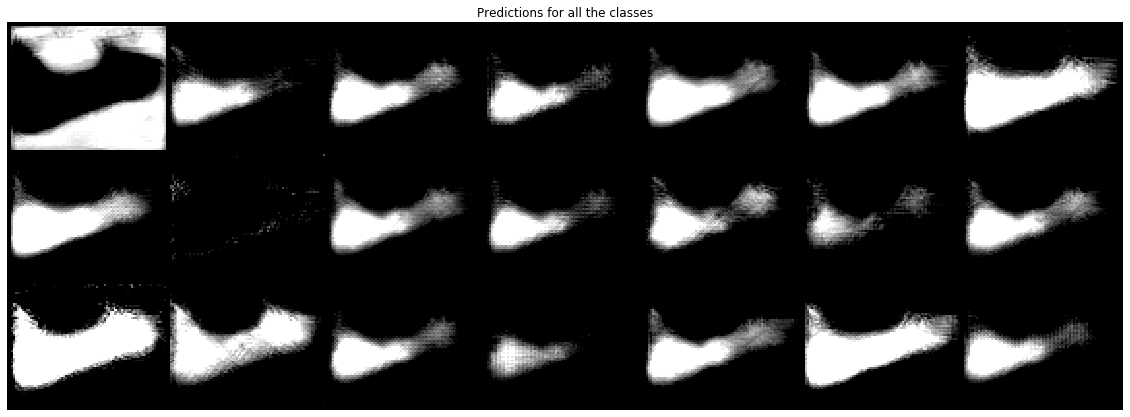

In [56]:
_index = 12
preds = predictions[_index].detach().numpy()
img = images[_index].numpy().transpose((1, 2, 0))

def plot_classes():
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    ax[0].title.set_text('Original')
    ax[0].imshow(img); 
    ax[1].title.set_text('Segmented')
    ax[1].imshow(preds.argmax(axis=0) / len(class_names), cmap='gray')
    plt.figure(figsize=(20, 8))
    plt.title('Sum of Activations of Segmented Pixels')
    plt.bar(class_names[1:], [max(x.sum(), 0) for x in preds][1:])
    im = torchvision.utils.make_grid(
        torch.Tensor(preds.reshape(-1, 1, *image_size)), 7)
    imshow(im, title='Predictions for all the classes')
    plt.show()

plot_classes()

## 8.2
Once you have done that, we want you to redesign a network where you remove to reinjection link (grey arrow on the drawing). You can remove the both from your choice just try and tell us if it's still working and why.

## 8.3 BONUSTOCOME

In [10]:
#TODO

In [44]:
torch.save(model.state_dict(), './saved/unet')

In [10]:
model.load_state_dict(torch.load('./saved/unet'))

<All keys matched successfully>